# End-To-End Data Pipeline

### Introduction

In this notebook we'll be showing how the data is processed by the model from the initial sentence in the source language. We'll see how the tokenized representation of the sentence is generated and fed to the model, then follow this data as it is processed to generate the model's tokenized output in the target language, then finally perform a final mapping to get our target language representation.

A diagram from the source paper, 'Attention is All You Need' Vaswani et al, is included below. The code that follows will be emulating how the data moves through the depicted model.

![Encoder-Decoder Transformer Architecture](transformer_architecture.PNG)

### Fetching the Input



In [1]:
import os, re, math, torch, tokenizers, torch.nn as nn, matplotlib.pyplot as plt

with open(f'{os.getcwd()}//data//europarl-v7.fr-en.en', mode='rt', encoding='utf-8') as f: # get source sentence
        srcLine = f.readlines()[13]

with open(f'{os.getcwd()}//data//europarl-v7.fr-en.fr', mode='rt', encoding='utf-8') as f: # get matching target sentence
        tgtLine = f.readlines()[13]

print(f"Source: {srcLine}")
print(f"Target: {tgtLine}")

tokenizer = tokenizers.Tokenizer.from_file(f"data//europarl_en_fr_shared_tokenizer.json")

srcLine = re.sub(r'(\w+)([.,?!])', r'\1 \2', srcLine).replace('\n','').strip().lower() + '<eos>' # seperate puncuation from words
tokens = tokenizer.encode(srcLine).ids # convert to embedding index

print(f"Token indexes: {tokens}")
valid_len = len(tokens)


print(f"Padded tokens: {[tokenizer.id_to_token(x) for x in tokens]}")

Source: Madam President, on a point of order.

Target: Madame la Présidente, c'est une motion de procédure.

Token indexes: [2640, 748, 205, 284, 191, 769, 243, 1331, 207, 3]
Padded tokens: ['▁madam', '▁president', '▁,', '▁on', '▁a', '▁point', '▁of', '▁order', '▁.', '<eos>']


Now we have a list of the indexes which map each word to their embeddings, and we can use this as an input to our transformer. First we load the model.

In [2]:
import model, settings, warnings

modelName = "Full"
params = settings.modelDict[modelName] # loading parameters for the full model

warnings.filterwarnings("ignore", category=UserWarning)
encoder = model.TransformerEncoder(tokenizer.get_vocab_size(), params["num_hiddens"], params["ffn_num_hiddens"], params["num_heads"], params["num_blks"], params["dropout"])
decoder = model.TransformerDecoder(tokenizer.get_vocab_size(), params["num_hiddens"], params["ffn_num_hiddens"], params["num_heads"], params["num_blks"], params["dropout"])
myModel = model.Seq2Seq(encoder, decoder, tgt_pad=tokenizer.token_to_id('<pad>'))
myModel.eval()

state = torch.load(f'{os.getcwd()}//checkpoints//{modelName}_en-fr.pth')
myModel.load_state_dict(state['model_state'])

# Now we have our model available, and can recreate the process of how our model makes predictions by accessing the underlying layers indvidually.

X = myModel.encoder.embedding(torch.tensor([tokens])) # wrap our tokens in a list to give us a batch size of one, then convert to embeddings
print(f"Embeddings:\n{X}\n")
print(f"Shape:{X.shape}")
X = myModel.encoder.pos_encoding(X * math.sqrt(params["num_hiddens"])) # Since positional encoding values are between -1 and 1, the embedding values are multiplied by the square root of the embedding dimension to rescale before they are summed up

C:\Users\sgawalsh\AppData\Local\Temp\ipykernel_17804\2593993492.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(f'{os.getcwd()}//checkpoints//{modelN

Embeddings:
tensor([[[ 1.0138,  0.9699,  0.8692,  ..., -1.0086,  2.8476,  0.7290],
         [-1.3306,  0.6401,  0.2260,  ..., -1.3788,  0.0470, -0.8041],
         [-1.2621, -0.0741,  0.0187,  ..., -0.2106,  0.5816, -0.9406],
         ...,
         [ 0.7721, -0.5149, -0.2957,  ...,  0.9177,  0.9080, -0.9684],
         [ 0.2074,  0.4447, -1.3799,  ...,  0.8991,  0.2173,  0.1851],
         [-0.1093, -1.4123,  0.0588,  ..., -0.9406,  0.4999, -1.3812]]],
       grad_fn=<EmbeddingBackward0>)

Shape:torch.Size([1, 10, 512])


### Encoder Block

We now have our embeddings ready and can load up a transformer block and perform the self attention process.

Attention Matrices shape: torch.Size([8, 10, 10])
Repeated lengths:
tensor([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10])
Head tensors shape: torch.Size([8, 10, 64])
Concatenated heads shape: torch.Size([1, 10, 512])


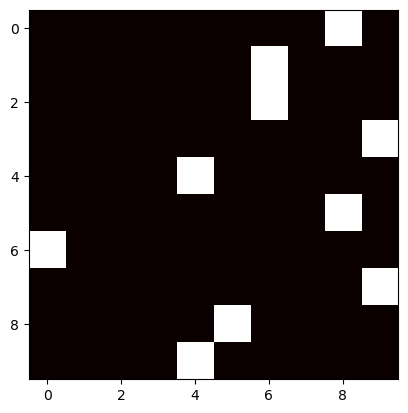

In [3]:
myEncBlock = myModel.encoder.blks[0]

norm_X = X

def transpose_qkv(X):
    # Shape of input X: (batch_size, no. of queries or key-value pairs, num_hiddens). Shape of output X: (batch_size, no. of queries or key-value pairs, num_heads, num_hiddens / num_heads)
    X = X.reshape(X.shape[0], X.shape[1], params["num_heads"], -1)
    # Shape of output X: (batch_size, num_heads, no. of queries or key-value pairs, num_hiddens / num_heads)
    X = X.permute(0, 2, 1, 3)
    # Shape of output: (batch_size * num_heads, no. of queries or key-value pairs, num_hiddens / num_heads)
    return X.reshape(-1, X.shape[2], X.shape[3])

# we get our queries, keys, and values from the linear layers from each block
queries = transpose_qkv(myEncBlock.attention.W_q(X))
keys = transpose_qkv(myEncBlock.attention.W_k(X))
values = transpose_qkv(myEncBlock.attention.W_v(X))

X = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(queries.shape[-1]) # generate our intial unmasked attention matrix for each head
shape = X.shape # save the shape so we can return to it later

print(f"Attention Matrices shape: {X.shape}")
X = X.reshape(-1, shape[-1])
valid_lens = torch.repeat_interleave(torch.tensor([valid_len]), shape[1] * params["num_heads"]) # generate our tensor for the masking process
print(f"Repeated lengths:\n{valid_lens}")

mask = torch.arange(1, X.size(1) + 1, dtype=torch.float32, device=X.device)[None, :] > valid_lens[:, None] # Generates a 'mask' to be applied to our attention matrix, where all values above the valid length of our input sentence are True, and all values below are False 
X[mask] = -1e6 # On the last axis, replace masked elements with a very large negative value, whose exponentiation outputs 0
X = nn.functional.softmax(X.reshape(shape), dim=-1) # cast back to original shape and apply softmax across last dimension

plt.imshow(X[0].cpu().detach().numpy(), cmap = 'hot') # sample output attention matrix of our first head

X = torch.bmm(X, values) # apply our final dot product attention function to re-establish our hidden dimension
print(f"Head tensors shape: {X.shape}")

# Now we perform a series of reshapings and permutations to concatenate the heads for each batch along the hidden dimension
X = X.reshape(-1, params["num_heads"], X.shape[1], X.shape[2])
X = X.permute(0, 2, 1, 3)
X = X.reshape(X.shape[0], X.shape[1], -1)
print(f"Concatenated heads shape: {X.shape}")

# We have now exited the self attention part of our block and can apply our final two layers, by adding a saved residual layer, and then performing another residual addition with the result and its output with a feed forward network
X = myEncBlock.addnorm1(norm_X, X)
X = myEncBlock.addnorm2(X, myEncBlock.ffn(X))

During that process we were able to output a graph showing our masked attention matrix. For each row, we see how much 'attention' one word pays to each of the other words in the sentence. The values beyond the valid_len limit have been zeroed by our mask on each row, but not on each column. However by applying the same process, we ensure those values will not be considered by the decoder.

This is the end of a single transformer block process, which are fed into eachother in sequence for as many blocks as have been set by the parameters. We'll move onto the decoder process from here, and take our encoder output directly from our model's encoder.

### Decoder Block

In [4]:
enc_valid_lens = torch.tensor([valid_len])

enc_all_outputs = myModel.encoder(torch.tensor([tokens]), torch.tensor([enc_valid_lens]))
print(f"Encoder context shape: {enc_all_outputs.shape}")

dec_state = [enc_all_outputs, enc_valid_lens, [None] * myModel.decoder.num_blks] # save encoder output and valid lengths to be referenced throughout process

outputs = [torch.full((enc_all_outputs.shape[0], 1), tokenizer.token_to_id('<bos>'))] # initialize output sentence with '<bos>' token
print(f"Initial output token index: {outputs}")

Encoder context shape: torch.Size([1, 10, 512])
Initial output token index: [tensor([[2]])]


The prediction loop consists of feeding the decoder the most recent output values. These values are used to generate a prediction which is added to the previous set of outputs. The loop can now be run again using the most recent output until the max length is reached. Each prediction cycle involves feeding the input through n blocks (set by the parameters of the model), where each block contains of two attention blocks. The first being a self attention block using only the predicted outputs up until that point, and the second combining the output of the first block with our values from the encoder.

Final predicted indicies: tensor([[1856,  235, 3688,  205,  197,  225,  318,  333, 3773,  216, 2291,  207,
            3,    0,    0]])
Translation: madame la présidente , c ' est une motion de procédure .


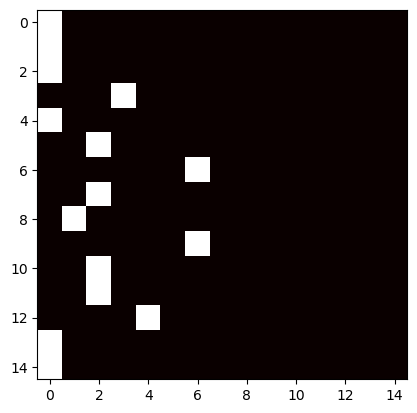

In [5]:
def decoderEmulator(X, state):
    X = decoder.pos_encoding(decoder.embedding(X) * math.sqrt(decoder.num_hiddens)) # inputs to embeddings
    decoder._attention_weights = [[None] * len(decoder.blks) for _ in range (2)]

    for i, blk in enumerate(decoder.blks):
        X, state = decoderBlockEmulator(blk, X, state) # we pass 'None' for the decoder valid lengths as during prediction all decoder values are considered
        decoder._attention_weights[0][i] = blk.attention1.attention.attention_weights # Decoder self-attention weights
        # print(blk.attention1.attention.attention_weights)
        if not i:
            prediction_weights.append(decoder._attention_weights[0][i][0]) # appending our decoder self attention weights from the first head of the first attention function of the first block to be displayed later
        decoder._attention_weights[1][i] = blk.attention2.attention.attention_weights # Encoder-decoder attention weights
        # plt.imshow(decoder._attention_weights[1][i][0].cpu().detach().numpy(), cmap = 'hot')
    
    return decoder.dense(X), state

def decoderBlockEmulator(myBlk, X, state):
    enc_outputs, enc_valid_lens = state[0], state[1]
    # During training, all the tokens of any output sequence are processed at the same time, so state[2][self.i] is None as initialized. When decoding any output sequence token by token during prediction, state[2][self.i] contains representations of the decoded output at the i-th block up to the current time step
    if state[2][myBlk.i] is None:
        key_values = X
    else:
        key_values = torch.cat((state[2][myBlk.i], X), dim=1) #append preds
    state[2][myBlk.i] = key_values
    # Self-attention
    X2 = myBlk.attention1(X, key_values, key_values, None)
    Y = myBlk.addnorm1(X, X2)
    # Encoder-decoder attention. Shape of enc_outputs:
    # (batch_size, num_steps, num_hiddens)
    Y2 = myBlk.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
    Z = myBlk.addnorm2(Y, Y2)
    return myBlk.addnorm3(Z, myBlk.ffn(Z)), state

prediction_weights = []
target_length = round(valid_len * 1.5) # we set a maximum length for our predicted sentence to be twice the length of our source sentence

for _ in range(target_length): 
    Y, dec_state = decoderEmulator(outputs[-1], dec_state) # latest predictions
    outputs.append(torch.argmax(Y, 2)) # append predictions
preds = torch.concat(outputs[1:], 1)

# We now have our predicted outputs and can use our target vocabulary to generate the translation
print(f"Final predicted indicies: {preds}")
translation = tokenizer.decode(preds[0].tolist())
print(f"Translation: {translation}")


padded_vectors = [torch.nn.functional.pad(v[0], (0, target_length - v.size(1))) for v in prediction_weights] # Pad each vector to target_length

out = torch.stack(padded_vectors)
plt.imshow(out.cpu().detach().numpy(), cmap = 'hot')

Because only outputs that have been generated up until that point are available, only the lower left triangle of the resulting attention matrix can be populated as the upper right values are not yet available to be considered.

Our final translation is generated by taking our output indexes and using our target vocabulary to generate the associated word tokens.